In [1]:
import torch

import os
# os.environ['TRITON_INTERPRET'] = '1'
import triton
import triton.language as tl
# import math

DEVICE = triton.runtime.driver.active.get_active_torch_device()

if torch.cuda.is_available():
    device = torch.cuda.current_device()
    props = torch.cuda.get_device_properties(device)
    
    print(f"Device: {props.name}")
    print(f"Compute Capability: {props.major}.{props.minor}")
    print(f"Total Memory: {props.total_memory / 1024**3:.2f} GB")
    # print(f"CUDA Cores: {props.multi_processor_count}")

Device: NVIDIA GeForce RTX 5070 Ti
Compute Capability: 12.0
Total Memory: 15.45 GB


In [2]:
def get_cuda_autotune_config():
    configs = []
    for num_warps, num_stages in [
        (4, 2),
        (4, 3),
        (4, 4),
        # (4, 5),
        # (8, 2),
        # (8, 4),
    ]:
        configs.append(
            triton.Config({"GROUP_SIZE_M" : 8, "BLOCK_SIZE_M" : 64, "BLOCK_SIZE_N" : 128, "BLOCK_SIZE_K" : 64}, num_stages=num_stages, num_warps=num_warps),
        )
        for GROUP_SIZE_M in [1]:
            for BLOCK_SIZE_M in [16, 32]:
                for BLOCK_SIZE_N in [16, 32, 64]:
                    for BLOCK_SIZE_K in [128, 256]:
                        configs.append(
                            triton.Config(
                                {
                                    "GROUP_SIZE_M" : GROUP_SIZE_M,
                                    "BLOCK_SIZE_M" : BLOCK_SIZE_M,
                                    "BLOCK_SIZE_N" : BLOCK_SIZE_N,
                                    "BLOCK_SIZE_K" : BLOCK_SIZE_K,
                                }, 
                                num_stages=num_stages, 
                                num_warps=num_warps
                            ),
                        )                        
    return configs
    return [triton.Config(
                                {
                                    "GROUP_SIZE_M" : 1,
                                    "BLOCK_SIZE_M" : 16,
                                    "BLOCK_SIZE_N" : 32,
                                    "BLOCK_SIZE_K" : 128,
                                },
                                num_stages=4,
                                num_warps=4
                            )]


In [3]:
@triton.autotune(
    configs=get_cuda_autotune_config(),
    key=['M', 'N', 'K'],
)
@triton.jit
def matmul_kernel_w4a16_tensor(
        # Pointers to matrices
        a_ptr, b_ptr, c_ptr, scale_ptr,
        # Matrix dimensions
        M, N, K,
        stride_am, stride_ak,  #
        stride_bk, stride_bn,  #
        stride_cm, stride_cn,
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  #
        GROUP_SIZE_M: tl.constexpr,
):

    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    tl.assume(pid_m >= 0)
    tl.assume(pid_n >= 0)
    tl.assume(stride_am > 0)
    tl.assume(stride_ak > 0)
    tl.assume(stride_bn > 0)
    tl.assume(stride_bk > 0)
    tl.assume(stride_cm > 0)
    tl.assume(stride_cn > 0)


    scale = tl.load(scale_ptr)

    offs_k = tl.arange(0, BLOCK_SIZE_K)
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    
    offs_bk = tl.arange(0, BLOCK_SIZE_K // 16)
    offs_bn = (pid_n * 2 * BLOCK_SIZE_N + tl.arange(0, 2 * BLOCK_SIZE_N)) % (2 * N)
    b_ptrs = b_ptr + ((offs_bk[:, None]) * stride_bk + offs_bn[None, :] * stride_bn)

    shifter = tl.arange(0, 8) * 4

    accumulator_dtype = tl.float32
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=accumulator_dtype)

    a_mask0 = (offs_am[:, None] < M) & (offs_k[None, :] < K)
    b_mask0 = (offs_bn[None, :] < 2 * N) & ((offs_bk[:, None]) < K // 16)
    a = tl.load(a_ptrs, mask=a_mask0, other=0.0)#, eviction_policy="evict_last")
    b_bits = tl.load(b_ptrs, mask=b_mask0, other=0)#, eviction_policy="evict_first")
    for k_idx in tl.range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        next_k_offset = (k_idx + 1) * BLOCK_SIZE_K
        
        if k_idx + 1 < tl.cdiv(K, BLOCK_SIZE_K):
            a_next_mask = (offs_am[:, None] < M) & (offs_k[None, :] + next_k_offset < K)
            b_next_mask = (offs_bn[None, :] < 2 * N) & ((offs_bk[:, None] + (next_k_offset // 16)) < K // 16)
            a_next = tl.load(a_ptrs + next_k_offset * stride_ak, mask=a_next_mask, other=0.0)#, eviction_policy="evict_last")
            b_bits_next = tl.load(b_ptrs + (next_k_offset // 16) * stride_bk, mask=b_next_mask, other=0)#, eviction_policy="evict_first")
        else:
            a_next = tl.zeros_like(a)
            b_bits_next = tl.zeros_like(b_bits)

        b = (b_bits[:, None, :] >> shifter[None, :, None]) & 0xF
        b = tl.reshape(b, (BLOCK_SIZE_K, BLOCK_SIZE_N))
        b = (b.to(tl.float16) - 7.5)
        
        accumulator = tl.dot(a, b, accumulator, out_dtype=accumulator_dtype)

        a = a_next
        b_bits = b_bits_next

    accumulator = accumulator * scale

    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, accumulator.to(tl.float16), mask=c_mask)


def triton_matmul_w4a16_tensor(a, b, scale):
    # Check constraints.
    assert a.shape[1] == b.shape[0] * 16, "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"

    assert a.dtype == torch.float16
    assert b.dtype == torch.int32
    
    M, K = a.shape
    N = b.shape[1] // 2
    
    assert scale.dtype == torch.float16
    assert len(scale.shape) == 1
    assert scale.shape[0] == 1
    
    # Allocates output.
    c = torch.empty((M, N), device=a.device, dtype=torch.float16)
    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )
    matmul_kernel_w4a16_tensor[grid](
        a, b, c, scale, #
        M, N, K,  #
        a.stride(0), a.stride(1),  #
        b.stride(0), b.stride(1),  #
        c.stride(0), c.stride(1),  #
    )
    return c


In [4]:
@triton.autotune(
    configs=get_cuda_autotune_config(),
    key=['M', 'N', 'K'],
)
@triton.jit
def matmul_kernel_w4a16_channel(
        # Pointers to matrices
        a_ptr, b_ptr, c_ptr, scale_ptr,
        # Matrix dimensions
        M, N, K,
        stride_am, stride_ak,  #
        stride_bk, stride_bn,  #
        stride_cm, stride_cn,
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  #
        GROUP_SIZE_M: tl.constexpr,
):

    # tl.assume(M == 1)
    # tl.assume(BLOCK_SIZE_M == 16)

    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    tl.assume(pid_m >= 0)
    tl.assume(pid_n >= 0)
    tl.assume(stride_am > 0)
    tl.assume(stride_ak > 0)
    tl.assume(stride_bn > 0)
    tl.assume(stride_bk > 0)
    tl.assume(stride_cm > 0)
    tl.assume(stride_cn > 0)

    offs_scale = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    scale_ptrs = scale_ptr + offs_scale
    scale = tl.load(scale_ptrs, mask=offs_scale < N)

    offs_k = tl.arange(0, BLOCK_SIZE_K)
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    
    offs_bk = tl.arange(0, BLOCK_SIZE_K // 16)
    offs_bn = (pid_n * 2 * BLOCK_SIZE_N + tl.arange(0, 2 * BLOCK_SIZE_N)) % (2 * N)
    b_ptrs = b_ptr + ((offs_bk[:, None]) * stride_bk + offs_bn[None, :] * stride_bn)

    shifter = tl.arange(0, 8) * 4

    accumulator_dtype = tl.float32
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=accumulator_dtype)

    a_mask0 = (offs_am[:, None] < M) & (offs_k[None, :] < K)
    b_mask0 = (offs_bn[None, :] < 2 * N) & ((offs_bk[:, None]) < K // 16)
    a = tl.load(a_ptrs, mask=a_mask0, other=0.0)#, eviction_policy="evict_last")
    b_bits = tl.load(b_ptrs, mask=b_mask0, other=0)#, eviction_policy="evict_first")
    for k_idx in tl.range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        next_k_offset = (k_idx + 1) * BLOCK_SIZE_K
        
        if k_idx + 1 < tl.cdiv(K, BLOCK_SIZE_K):
            a_next_mask = (offs_am[:, None] < M) & (offs_k[None, :] + next_k_offset < K)
            b_next_mask = (offs_bn[None, :] < 2 * N) & ((offs_bk[:, None] + (next_k_offset // 16)) < K // 16)
            a_next = tl.load(a_ptrs + next_k_offset * stride_ak, mask=a_next_mask, other=0.0)#, eviction_policy="evict_last")
            b_bits_next = tl.load(b_ptrs + (next_k_offset // 16) * stride_bk, mask=b_next_mask, other=0)#, eviction_policy="evict_first")
        else:
            a_next = tl.zeros_like(a)
            b_bits_next = tl.zeros_like(b_bits)

        b = (b_bits[:, None, :] >> shifter[None, :, None]) & 0xF
        b = tl.reshape(b, (BLOCK_SIZE_K, BLOCK_SIZE_N))
        b = (b.to(tl.float16) - 7.5)
        

        accumulator = tl.dot(a, b, accumulator, out_dtype=accumulator_dtype)

        a = a_next
        b_bits = b_bits_next

    accumulator = accumulator * scale[None, :]

    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, accumulator.to(tl.float16), mask=c_mask)


def triton_matmul_w4a16_channel(a, b, scale):
    # Check constraints.
    assert a.shape[1] == b.shape[0] * 16, "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"

    assert a.dtype == torch.float16
    assert b.dtype == torch.int32
    

    M, K = a.shape
    N = b.shape[1] // 2

    assert scale.dtype == torch.float16
    assert len(scale.shape) == 1
    assert scale.shape[0] == N


    # Allocates output.
    c = torch.empty((M, N), device=a.device, dtype=torch.float16)
    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )
    matmul_kernel_w4a16_channel[grid](
        a, b, c, scale,
        M, N, K,
        a.stride(0), a.stride(1),
        b.stride(0), b.stride(1),
        c.stride(0), c.stride(1),
    )
    return c


In [5]:
@triton.autotune(
    configs=get_cuda_autotune_config(),
    key=['M', 'N', 'K'],
)
@triton.jit
def matmul_kernel_w4a16_gs256(
        # Pointers to matrices
        a_ptr, stride_am, stride_ak,
        b_ptr, stride_bk, stride_bn,
        c_ptr, stride_cm, stride_cn,
        s_ptr, stride_sk, stride_sn,
        # Matrix dimensions
        M, N, K,
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  #
        GROUP_SIZE_M: tl.constexpr,
):
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    tl.assume(pid_m >= 0)
    tl.assume(pid_n >= 0)
    tl.assume(stride_am > 0)
    tl.assume(stride_ak > 0)
    tl.assume(stride_bn > 0)
    tl.assume(stride_bk > 0)
    tl.assume(stride_cm > 0)
    tl.assume(stride_cn > 0)

    # offs_sk = tl.arange(0, tl.max(1, BLOCK_SIZE_K // 256))
    offs_sk = tl.arange(0, 1)
    offs_sn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    s_ptrs = s_ptr + ((offs_sk[:, None]) * stride_sk + offs_sn[None, :] * stride_sn)

    offs_k = tl.arange(0, BLOCK_SIZE_K)
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    
    offs_bk = tl.arange(0, BLOCK_SIZE_K // 16)
    offs_bn = (pid_n * 2 * BLOCK_SIZE_N + tl.arange(0, 2 * BLOCK_SIZE_N)) % (2 * N)
    b_ptrs = b_ptr + ((offs_bk[:, None]) * stride_bk + offs_bn[None, :] * stride_bn)

    shifter = tl.arange(0, 8) * 4

    accumulator_dtype = tl.float32
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=accumulator_dtype)

    a_mask0 = (offs_am[:, None] < M) & (offs_k[None, :] < K)
    b_mask0 = (offs_bn[None, :] < 2 * N) & ((offs_bk[:, None]) < K // 16)
    a = tl.load(a_ptrs, mask=a_mask0, other=0.0)#, eviction_policy="evict_last")
    b_bits = tl.load(b_ptrs, mask=b_mask0, other=0)#, eviction_policy="evict_first")
    scale = tl.load(s_ptrs)

    for k_idx in tl.range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        next_k_offset = (k_idx + 1) * BLOCK_SIZE_K
        
        if k_idx + 1 < tl.cdiv(K, BLOCK_SIZE_K):
            a_next_mask = (offs_am[:, None] < M) & (offs_k[None, :] + next_k_offset < K)
            b_next_mask = (offs_bn[None, :] < 2 * N) & ((offs_bk[:, None] + (next_k_offset // 16)) < K // 16)
            a_next = tl.load(a_ptrs + next_k_offset * stride_ak, mask=a_next_mask, other=0.0)#, eviction_policy="evict_last")
            b_bits_next = tl.load(b_ptrs + (next_k_offset // 16) * stride_bk, mask=b_next_mask, other=0)#, eviction_policy="evict_first")
            
            scale_next = tl.load(s_ptrs + next_k_offset // 256 * stride_sk)
        else:
            a_next = tl.zeros_like(a)
            b_bits_next = tl.zeros_like(b_bits)
            scale_next = tl.zeros_like(scale)

        b = (b_bits[:, None, :] >> shifter[None, :, None]) & 0xF
        b = tl.reshape(b, (BLOCK_SIZE_K, BLOCK_SIZE_N))
        b = (b.to(tl.float16) - 7.5)
        
        b *= scale

        accumulator = tl.dot(a, b, accumulator, out_dtype=accumulator_dtype)

        a = a_next
        b_bits = b_bits_next
        scale = scale_next

    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, accumulator.to(tl.float16), mask=c_mask)


def triton_matmul_w4a16_gs256(a, b, scale):
    # Check constraints.
    assert a.shape[1] == b.shape[0] * 16, "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"

    assert a.dtype == torch.float16
    assert b.dtype == torch.int32
    

    M, K = a.shape
    N = b.shape[1] // 2

    assert scale.dtype == torch.float16
    assert len(scale.shape) == 2
    assert scale.shape[0] == K // 256
    assert scale.shape[1] == N


    # Allocates output.
    c = torch.empty((M, N), device=a.device, dtype=torch.float16)
    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )
    matmul_kernel_w4a16_gs256[grid](
        a, a.stride(0), a.stride(1),
        b, b.stride(0), b.stride(1),
        c, c.stride(0), c.stride(1),
        scale, scale.stride(0), scale.stride(1),
        M, N, K,
    )
    return c


In [6]:
# torch.manual_seed(0)

# M, N, K = 256, 1024, 1024

# y_fp16 = torch.randn(M, K, dtype=torch.float16, device="cuda") / (M * K)

# x_compressed = torch.randint(-2**31, 2**31, (K // 16, N * 2), dtype=torch.int32, device="cuda")
# tensor_scale = torch.randn(1, dtype=torch.float16, device="cuda")
# channel_scale = torch.randn(N, dtype=torch.float16, device="cuda")
# group256_scale = torch.randn((K // 256, N), dtype=torch.float16, device="cuda")

# triton_tensor_out = triton_matmul_w4a16_tensor(y_fp16, x_compressed, tensor_scale)
# triton_channel_out = triton_matmul_w4a16_channel(y_fp16, x_compressed, channel_scale)
# triton_gs256_out = triton_matmul_w4a16_gs256(y_fp16, x_compressed, group256_scale)


In [7]:
# shifter = (torch.arange(0, 8) * 4).cuda()
# _K, _N = x_compressed.shape

# # gs256
# if 1:
#     kernel_params = matmul_kernel_w4a16_gs256.best_config.__dict__['kwargs']
#     bs_k, bs_n = kernel_params["BLOCK_SIZE_K"], kernel_params["BLOCK_SIZE_N"]

#     x_decompressed = x_compressed.reshape(_K // (bs_k // 16), bs_k // 16, _N // (bs_n * 2), bs_n * 2).transpose(1, 2)
#     x_decompressed = (x_decompressed[:, :, :, None, :] >> shifter[None,None,None, :, None]) & 0xF
#     x_decompressed = x_decompressed.reshape(K // bs_k, N // bs_n, bs_k,  bs_n).transpose(1,2).reshape(K, N)

#     x_decompressed = x_decompressed.to(torch.float16) - 7.5
#     x_decompressed = (x_decompressed.reshape(K // 256, 256, N) * group256_scale[:, None, :]).reshape(K, N)
#     gs256_out = y_fp16 @ x_decompressed 

#     print("\ngs256:")
#     # print(triton_gs256_out)
#     # print(gs256_out)
#     diff = ((triton_gs256_out - gs256_out) / (gs256_out.abs() + 1e-6)).abs().max()
#     print("Relative error:", diff)

# # channel
# if 0:
#     kernel_params = matmul_kernel_w4a16_channel.best_config.__dict__['kwargs']
#     bs_k, bs_n = kernel_params["BLOCK_SIZE_K"], kernel_params["BLOCK_SIZE_N"]

#     x_decompressed = x_compressed.reshape(_K // (bs_k // 16), bs_k // 16, _N // (bs_n * 2), bs_n * 2).transpose(1, 2)
#     x_decompressed = (x_decompressed[:, :, :, None, :] >> shifter[None,None,None, :, None]) & 0xF
#     x_decompressed = x_decompressed.reshape(K // bs_k, N // bs_n, bs_k,  bs_n).transpose(1,2).reshape(K, N)

#     x_decompressed = x_decompressed.to(torch.float16) - 7.5
#     channel_out = y_fp16 @ x_decompressed * channel_scale[None, :]
#     print("\nchannel:")
#     # print(triton_channel_out)
#     # print(channel_out)
#     diff = ((triton_channel_out - channel_out) / (channel_out.abs() + 1e-6)).abs().max()
#     print("Relative error:", diff)

# # tensor
# if 0:
#     kernel_params = matmul_kernel_w4a16_tensor.best_config.__dict__['kwargs']
#     bs_k, bs_n = kernel_params["BLOCK_SIZE_K"], kernel_params["BLOCK_SIZE_N"]

#     x_decompressed = x_compressed.reshape(_K // (bs_k // 16), bs_k // 16, _N // (bs_n * 2), bs_n * 2).transpose(1, 2)
#     x_decompressed = (x_decompressed[:, :, :, None, :] >> shifter[None,None,None, :, None]) & 0xF
#     x_decompressed = x_decompressed.reshape(K // bs_k, N // bs_n, bs_k,  bs_n).transpose(1,2).reshape(K, N)

#     x_decompressed = x_decompressed.to(torch.float16) - 7.5
#     tensor_out = (y_fp16 @ x_decompressed) * tensor_scale

#     print("\ntensor:")
#     # print(triton_tensor_out)
#     # print(tensor_out)
#     diff = ((triton_tensor_out - tensor_out) / (tensor_out.abs() + 1e-6)).abs().max()
#     print("Relative error:", diff)



[M x K x N]: [16 x 2048 x 2048]
matmul_kernel_w4a16_tensor: GROUP_SIZE_M: 1, BLOCK_SIZE_M: 32, BLOCK_SIZE_N: 16, BLOCK_SIZE_K: 256, num_warps: 4, num_ctas: 1, num_stages: 4, maxnreg: None
matmul_kernel_w4a16_channel: GROUP_SIZE_M: 1, BLOCK_SIZE_M: 16, BLOCK_SIZE_N: 16, BLOCK_SIZE_K: 256, num_warps: 4, num_ctas: 1, num_stages: 2, maxnreg: None
matmul_kernel_w4a16_gs256: GROUP_SIZE_M: 1, BLOCK_SIZE_M: 16, BLOCK_SIZE_N: 16, BLOCK_SIZE_K: 256, num_warps: 4, num_ctas: 1, num_stages: 4, maxnreg: None

[M x K x N]: [16 x 4096 x 4096]
matmul_kernel_w4a16_tensor: GROUP_SIZE_M: 1, BLOCK_SIZE_M: 16, BLOCK_SIZE_N: 32, BLOCK_SIZE_K: 256, num_warps: 4, num_ctas: 1, num_stages: 4, maxnreg: None
matmul_kernel_w4a16_channel: GROUP_SIZE_M: 1, BLOCK_SIZE_M: 16, BLOCK_SIZE_N: 32, BLOCK_SIZE_K: 256, num_warps: 4, num_ctas: 1, num_stages: 4, maxnreg: None
matmul_kernel_w4a16_gs256: GROUP_SIZE_M: 1, BLOCK_SIZE_M: 16, BLOCK_SIZE_N: 32, BLOCK_SIZE_K: 256, num_warps: 4, num_ctas: 1, num_stages: 3, maxnreg: Non

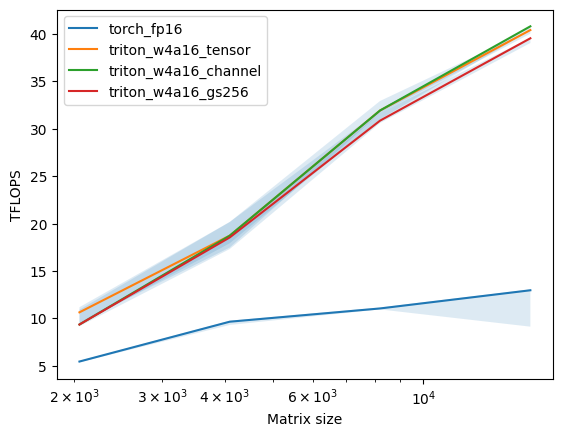

In [8]:
BS = 16
sizes = [2**11, 2**12, 2**13, 2**14]

BSs = [1, 16, 32, 128, 1024]
size = 4096

experiments = [
            "torch_fp16",
            "triton_w4a16_tensor",
            "triton_w4a16_channel",
            "triton_w4a16_gs256",
            ]

configs = []
configs.append(
    triton.testing.Benchmark(
        x_names=["K", "M", "N"],  # Argument names to use as an x-axis for the plot
        x_vals=[(size, BS, size) for size in sizes],
        # x_names=["M", "K", "N"],  # Argument names to use as an x-axis for the plot
        # x_vals=[(BS, size, size) for BS in BSs],
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        line_vals=experiments,
        line_names=experiments,
        ylabel="TFLOPS",  # Label name for the y-axis
        xlabel="Matrix size",
        plot_name="matmul-performance",  # Name for the plot, used also as a file name for saving the plot.
        args={},
        x_log=True,
    ))


@triton.testing.perf_report(configs)
def benchmark(M, K, N, provider):
    y_fp16 = torch.randn(M, K, dtype=torch.float16, device="cuda") / (M * K)
    x_fp16 = torch.randn(K, N, dtype=torch.float16, device="cuda") / (M * K)
    
    x_compressed_4bit = torch.randint(-2**31, 2**31, (K // 16, N * 2), dtype=torch.int32, device="cuda")
    tensor_scale = torch.randn(1, dtype=torch.float16, device="cuda")
    channel_scale = torch.randn(N, dtype=torch.float16, device="cuda")
    group256_scale = torch.randn((K // 256, N), dtype=torch.float16, device="cuda")
    
    
    quantiles = [0.5, 0.2, 0.8]
    if provider == "torch_fp16":
        print(f"\n[M x K x N]: [{M} x {K} x {N}]")
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(y_fp16, x_fp16), quantiles=quantiles)
    
    if provider == "triton_w4a16_tensor":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_matmul_w4a16_tensor(y_fp16, x_compressed_4bit, tensor_scale), quantiles=quantiles)
        print("matmul_kernel_w4a16_tensor:", matmul_kernel_w4a16_tensor.best_config)

    if provider == "triton_w4a16_channel":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_matmul_w4a16_channel(y_fp16, x_compressed_4bit, channel_scale), quantiles=quantiles)
        print("matmul_kernel_w4a16_channel:", matmul_kernel_w4a16_channel.best_config)

    if provider == "triton_w4a16_gs256":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_matmul_w4a16_gs256(y_fp16, x_compressed_4bit, group256_scale), quantiles=quantiles)
        print("matmul_kernel_w4a16_gs256:", matmul_kernel_w4a16_gs256.best_config)

    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)

benchmark.run(show_plots=False, print_data=True)

In [9]:
# def swizzle(x):
#     M, N = x.shape
#     x = (x.reshape(M // 2, 2, N // 2, 2) \
#         .transpose(1, 2) \
#         .transpose(2, 3) \
#         .transpose(1, 2) \
#         .reshape(M, N)
#         )
#     return x

# N, M = 8, 8

# x = torch.arange(N * M, dtype=torch.uint8).reshape(N, M)
# print(x)
# print(swizzle(x))